# Introduction et problématisation

# Aperçu de la base de données et nettoyage
  ## Installation de tous les packages nécessaires au projet

In [184]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from urllib import request
import csv
import bs4
from tqdm import tqdm_notebook
import seaborn as sns

## Aperçu de la base initiale

La base que nous avons décidé de choisir pour mener à bien notre projet est issue du site The Movie Database, BLABLABLA

Le dataset est disponible à l'adresse suivante : https://www.kaggle.com/rounakbanik/the-movies-dataset

In [149]:
base_init = pd.read_csv("clean_base_V0.csv")
base_init.head(5)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,production_companies_name,production_companies_id,country_code,country_name
0,0,False,"{""id"": 10194, ""name"": ""Toy Story Collection"", ...",30000000,"[{""id"": 16, ""name"": ""Animation""}, {""id"": 35, ""...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy""s toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{""name"": ""Pixar Animation Studios"", ""id"": 3}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1995-10-30,373554033.0,81.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,NaN,Toy Story,False,7.7,5415.0,"""Pixar Animation Studios""",3.0,"""US""","""United States of America"""
1,1,False,NaN,65000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{""name"": ""TriStar Pictures"", ""id"": 559}, {""na...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1995-12-15,262797249.0,104.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"""TriStar Pictures""",559.0,"""US""","""United States of America"""
2,2,False,"{""id"": 119050, ""name"": ""Grumpy Old Men Collect...",0,"[{""id"": 10749, ""name"": ""Romance""}, {""id"": 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{""name"": ""Warner Bros."", ""id"": 6194}, {""name""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1995-12-22,0.0,101.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"""Warner Bros.""",6194.0,"""US""","""United States of America"""
3,3,False,NaN,16000000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,"[{""name"": ""Twentieth Century Fox Film Corporat...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1995-12-22,81452156.0,127.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"""Twentieth Century Fox Film Corporation""",306.0,"""US""","""United States of America"""
4,4,False,"{""id"": 96871, ""name"": ""Father of the Bride Col...",0,"[{""id"": 35, ""name"": ""Comedy""}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{""name"": ""Sandollar Productions"", ""id"": 5842}...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1995-02-10,76578911.0,106.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Just When His World Is Back To Normal... He""s ...",Father of the Bride Part II,False,5.7,173.0,"""Sandollar Productions""",5842.0,"""US""","""United States of America"""


On regarde tout d'abord si la base comporte beaucoup de cellules vide:

Text(0.5, 1.0, 'Complétude de la base, en blanc les valeurs manquantes')

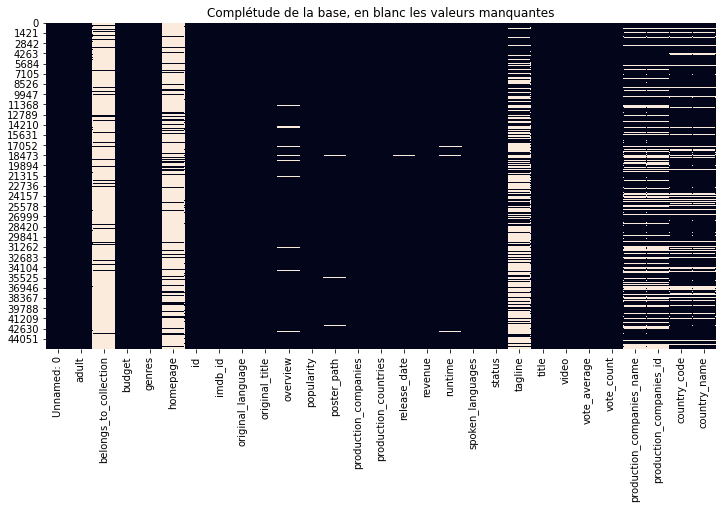

In [185]:
fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(base_init.isnull(), cbar=False)
plt.title('Complétude de la base, en blanc les valeurs manquantes')

## Détails des colonnes de la base

# Nettoyage de la base

On commence par retirer toute la ponctuation, qui ne nous servira pas.

In [186]:
base_init.production_companies_name = base_init.production_companies_name.str.replace(r'[^\w\s]+', '')
base_init.production_companies= base_init.production_companies.str.replace(r'[^\w\s]+', '')
base_init.genres = base_init.genres.str.replace(r'[^\w\s]+', '')
base_init.production_countries = base_init.production_countries.str.replace(r'[^\w\s]+', '')
base_init.spoken_languages = base_init.spoken_languages.str.replace(r'[^\w\s]+', '')
base_init.country_code = base_init.country_code.str.replace(r'[^\w\s]+', '')
base_init.country_name = base_init.country_name.str.replace(r'[^\w\s]+', '')

Nous obtenons alors ce résultat-ci :

In [187]:
base_init.head(2)

,Unnamed: 0,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,production_companies_name,production_companies_id,country_code,country_name
0,0,False,"{""id"": 10194, ""name"": ""Toy Story Collection"", ...",30000000,Animation Comedy Family,http://toystory.disney.com/toy-story,862,tt0114709,Anglais,Toy Story,"Led by Woody, Andy""s toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,name Pixar Animation Studios id 3,iso_3166_1 US name United States of America,1995-10-30,373554033.0,81.0,Anglais,Released,NaN,Toy Story,False,7.7,5415.0,Pixar Animation Studios,3.0,US,United States of America
1,1,False,NaN,65000000,Adventure Fantasy Family,NaN,8844,tt0113497,Anglais,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,name TriStar Pictures id 559 name Teitler Film...,iso_3166_1 US name United States of America,1995-12-15,262797249.0,104.0,Anglais Français,Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,TriStar Pictures,559.0,US,United States of America


Nous remarquons que conserver certains mots dans les cellules de la base, tels que les 'id', 'name', ne sont pas pertinents. Par ailleurs, il sera plus lisible de pouvoir associer les identifiants de langue ISO_639-1 à leur langue dans les colonnes 'original_language' et 'spoken_language'. Ces deux objectifs sont l'objet des sections suivantes.



## Scraping de la liste ISO_639-1

Cette liste est disponible sur l'url suivante : https://fr.wikipedia.org/wiki/Liste_des_codes_ISO_639-1.

Nous allons récupérer les identifiants, ainsi que les langues correspondantes:

In [194]:
url_iso = "https://fr.wikipedia.org/wiki/Liste_des_codes_ISO_639-1"
    
request_text = request.urlopen(url_iso).read()
page = bs4.BeautifulSoup(request_text, "lxml")

Les informations que nous désirons étant contenues dans un tableau, on le récupère puis on le convertit en Data Frame

In [189]:
table = page.find('table')
ls = str(table)
liste_iso = pd.DataFrame(pd.read_html(ls)[0])
liste_iso

,639-1,639-2,639-3,Nom de la langue,Nom(dans la langue correspondante),Nom en anglais,Commentaire
0,aa,aar,aar,Afar,Afaraf,Afar,NaN
1,ab,abk,abk,Abkhaze,Аҧсуа,Abkhazian,NaN
2,ae,ave,ave,Avestique,Avesta,Avestan,NaN
3,af,afr,afr,Afrikaans,Afrikaans,Afrikaans,NaN
4,ak,aka,aka + 2,Akan,Akan,Akan,NaN
...,...,...,...,...,...,...,...
182,yi,yid,yid + 2,Yiddish,ייִדיש,Yiddish,NaN
183,yo,yor,yor,Yoruba,Yorùbá,Yoruba,NaN
184,za,zha,zha + 2,Zhuang,Saɯ cueŋƅ ; Saw cuengh,Zhuang,NaN
185,zh,chi/zho,zho + 13,Chinois,"中文, 汉语, 漢語",Chinese,NaN


Après une étude approfondie de la base, nous avons constaté que certains films possédaient l'identifiant 'cn' correspondant au cantonais. On le rajoute au Data Frame précédent: 

In [190]:
liste_iso.loc[187] = ['cn', 'NaN', 'NaN', 'Cantonais', 'NaN', 'Cantonese', 'NaN']
liste_iso

,639-1,639-2,639-3,Nom de la langue,Nom(dans la langue correspondante),Nom en anglais,Commentaire
0,aa,aar,aar,Afar,Afaraf,Afar,NaN
1,ab,abk,abk,Abkhaze,Аҧсуа,Abkhazian,NaN
2,ae,ave,ave,Avestique,Avesta,Avestan,NaN
3,af,afr,afr,Afrikaans,Afrikaans,Afrikaans,NaN
4,ak,aka,aka + 2,Akan,Akan,Akan,NaN
...,...,...,...,...,...,...,...
183,yo,yor,yor,Yoruba,Yorùbá,Yoruba,NaN
184,za,zha,zha + 2,Zhuang,Saɯ cueŋƅ ; Saw cuengh,Zhuang,NaN
185,zh,chi/zho,zho + 13,Chinois,"中文, 汉语, 漢語",Chinese,NaN
186,zu,zul,zul,Zoulou,isiZulu,Zulu,NaN


La fonction suivante permettra de récupérer la langue associée à un identifiant ISO_639-1:

In [191]:
def find_id(id):
  i = 0
  while (str((liste_iso['639-1'])[i]) == id) == False:
    i += 1
  return liste_iso['Nom de la langue'][i]

## Nettoyage de la variable 'original_language'

On teste la fonction sur la première entrée de la colonne 'original_language'

In [192]:
test = str('en')
find_id(test)

'Anglais'

Puis on généralise la méthode à toutes les cellules de cette colonne :

In [193]:
for i in range(len(base_init)):
  id = str(base_init.original_language[i])
  base_init.original_language[i] = find_id(id)

KeyError: ignored

In [ ]:
base_init.original_language[4000]

## Nettoyage des variables 'genre' et 'spoken_language'

Le but de cette partie est de supprimer les informations non-essentielles qui se trouvent dans les cellules de ces colonnes.

On s'intéresse dans un premier temps à la colonne 'genres'.

In [ ]:
base_init.genres[0]

Dans cet exemple, il nous faut seulement les mots 'Animation', 'Comedy' et 'Family'. Grâce à la fonction split(), nous pouvons transformer cette chaîne de caractère en liste, puis récupérer les mots qui nous intéressent. Le code suivant réalise cette opération pour toutes les cellules de cette colonne


In [ ]:
for i in range(len(base_init)):
  genre = base_init.genres[i].split()
  base_init.genres[i] = ""
  for j in range(len(genre)//4):
    if j == 0 :
      base_init.genres[i] = base_init.genres[i] + genre[3 + j*4]
    else : 
      base_init.genres[i] = base_init.genres[i] + ', ' + genre[3 + j*4]

In [ ]:
base_init.genres

Intéressons nous désormais à la colonne spoken_language :

In [ ]:
base_init.spoken_languages

Nous remarquons que les cellules de cette colonne ont la même structure que celles de la colonne 'genre'. Ici, nous souhaitons garder les identifiants iso_639_1 ('en' pour la première ligne). Nous pourrons ensuite les associer à une langue grâce à la base liste_iso.

Puis on nettoie la colonne 'spoken language' et on associe l'identifiant iso_639_1 à sa langue.

In [ ]:
for i in range(len(base_init)):
  langue = base_init.spoken_languages[i].split()
  base_init.spoken_languages[i] = ""
  for j in range(len(langue)//4):
    if j == 0 :
      base_init.spoken_languages[i] = base_init.spoken_languages[i] + find_id(str(langue[1 + j*4]))
    else : 
      base_init.spoken_languages[i] = base_init.spoken_languages[i] + ', ' + find_id(str(langue[1 + j*4]))
  

In [ ]:
base_init.spoken_languages

# Statistiques descriptives

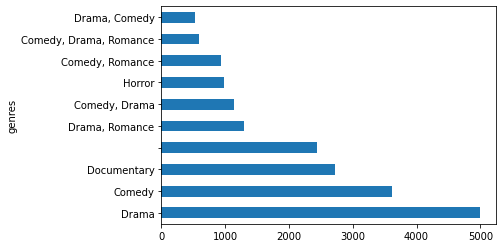

In [181]:
base_init.groupby(base_init['genres']).id.count().sort_values(ascending = False)[:10].plot(kind = 'barh')

# Modélisation